# Imports

In [1]:
import pandas as pd
import time

from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

import tweepy
#from auth import auth #Inserir autenticação no arquivo auth.py
from grabel_auth import auth

import warnings
warnings.filterwarnings('ignore')

# API object

* [AUTENTICAÇÕES DO TWITTER](https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively./#:~:text=Application%20only%20auth%20has%20higher,Auth%20using%20the%20Tweepy%20API.)

In [2]:
tt = auth()

# Functions

## count_down

In [3]:
# count down
def count_down(tempo):
    while tempo:
        mins, secs = divmod(tempo, 60)
        timeformat = '{:02d}:{:02d}'.format(mins, secs)
        print(timeformat, end='\r')
        time.sleep(1)
        tempo -= 1

In [4]:
count_down(3)

## get_followers_id()

In [5]:
# get_followers_id()

def get_followers_ids(perfil_analisado):
    '''Recebe um nome de perfil do twitter e retorna serie com ids dos seguidores'''
    ids = []
    my_pages = tweepy.Cursor(tt.followers_ids, screen_name=perfil_analisado).pages()
    while True:
        try:
            page = my_pages.next()
            ids.extend(page)
            time.sleep(2)
        except tweepy.TweepError:
                tempo = (60 * 15) #15 min
                time.sleep(tempo)
                print('oi')
                while tempo:
                    mins, secs = divmod(tempo, 60)
                    timeformat = '{:02d}:{:02d}'.format(mins, secs)
                    print(timeformat, end='\r')
                    time.sleep(1)
                    tempo -= 1 #não está printando a contagem regressiva!
                continue
        except StopIteration:
            break
  
    return pd.DataFrame(ids, columns=['followers_ids'])['followers_ids']


* Exemplo:

In [6]:
followers = get_followers_ids('grabel')
type(followers)

pandas.core.series.Series

## get_users_data()

In [7]:
# get_users_data()
def get_users_data(lista_ids):
    '''Recebe lista ou serie de ids e retorna nomes de perfis do twitter'''
    followers = pd.DataFrame()
    while len(lista_ids)>len(followers):
        try:
            for tt_id in tqdm(lista_ids):
                df = pd.DataFrame(tt.get_user(tt_id)._json)
                df = df.loc[['description'],['id_str','name','screen_name','profile_image_url_https',
                                             'description','statuses_count','friends_count','followers_count',
                                             'favourites_count','location','created_at','protected','lang']].rename(
                                                                                    columns={
                                                                                              'statuses_count':'tweets_count',
                                                                                              'id_str':'profile_id'
                                                                                              })
                followers = pd.concat([followers, df], axis = 0, ignore_index=True)  
                time.sleep(.5)
                
        except tweepy.TweepError:
                tempo = (60 * 15) #15 min
                time.sleep(tempo)
                count_down(tempo)
                continue
        except StopIteration:
            break
        
    return followers

* Exemplo:

In [8]:
df_users = get_users_data(followers[:2])
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   profile_id               2 non-null      object
 1   name                     2 non-null      object
 2   screen_name              2 non-null      object
 3   profile_image_url_https  2 non-null      object
 4   description              2 non-null      object
 5   tweets_count             2 non-null      int64 
 6   friends_count            2 non-null      int64 
 7   followers_count          2 non-null      int64 
 8   favourites_count         2 non-null      int64 
 9   location                 2 non-null      object
 10  created_at               2 non-null      object
 11  protected                2 non-null      bool  
 12  lang                     0 non-null      object
dtypes: bool(1), int64(4), object(8)
memory usage: 322.0+ bytes


## get_followers_data()

In [9]:
# get_followers_data()
def get_followers_data(perfil_analisado):
    '''Recebe perfil e retorna dataframe com dados das páginas dos seguidores'''
    df_fol = get_followers_ids(perfil_analisado)
    return get_users_data(df_fol)

* Exemplo:

In [10]:
df_followers = get_followers_data('grabel')
df_followers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   profile_id               172 non-null    object
 1   name                     172 non-null    object
 2   screen_name              172 non-null    object
 3   profile_image_url_https  172 non-null    object
 4   description              172 non-null    object
 5   tweets_count             172 non-null    int64 
 6   friends_count            172 non-null    int64 
 7   followers_count          172 non-null    int64 
 8   favourites_count         172 non-null    int64 
 9   location                 172 non-null    object
 10  created_at               172 non-null    object
 11  protected                172 non-null    bool  
 12  lang                     0 non-null      object
dtypes: bool(1), int64(4), object(8)
memory usage: 16.4+ KB


## get_seguidores_iguais()

In [11]:
# get_seguidores_iguais()
def get_seguidores_iguais(*tt_users):
    '''Recebe nomes de perfis do twitter e retorna serie com seguidores em comum.'''
    
    tt_users = list(tt_users) 
    print('Perfis a filtrar:', len(tt_users))
    if len(tt_users)>=2:
                    
        fols_user1 = get_followers_ids(tt_users.pop(0))
        
        clear_output(wait=True)
        print('Perfis a filtrar:', len(tt_users))
        fols_user2 = get_followers_ids(tt_users.pop(0))
        df_both = pd.merge(fols_user2, fols_user1, how = 'inner', on='followers_ids')
        
        while len(tt_users)>=1:
            
            clear_output(wait=True)
            print('Perfis a filtrar:', len(tt_users))
            
            fols_userx = get_followers_ids(tt_users.pop(0))
            df_both = pd.merge(df_both, fols_userx, how='inner', on ='followers_ids')
           
        clear_output(wait=True)
        print('Seguidores em comum: ', len(df_both))
        
    return get_users_data(df_both['followers_ids'])  

* Exemplo:

In [12]:
seguidores_em_comum = get_seguidores_iguais('twitter_1',
                                            'twitter_2',
                                            'twitter_n'
                                             )

Seguidores em comum:  31


In [13]:
seguidores_em_comum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   profile_id               31 non-null     object
 1   name                     31 non-null     object
 2   screen_name              31 non-null     object
 3   profile_image_url_https  31 non-null     object
 4   description              31 non-null     object
 5   tweets_count             31 non-null     int64 
 6   friends_count            31 non-null     int64 
 7   followers_count          31 non-null     int64 
 8   favourites_count         31 non-null     int64 
 9   location                 31 non-null     object
 10  created_at               31 non-null     object
 11  protected                31 non-null     bool  
 12  lang                     0 non-null      object
dtypes: bool(1), int64(4), object(8)
memory usage: 3.1+ KB


## plot_tt_top()

In [14]:
# plot_tt_top()
def plot_tt_top(df = [], top=10, table = False):
        
    l = 25
    h = min(top*2.2, 150)
    cols = {'flls':'followers_count',
            'frds':'friends_count',
            'twts':'tweets_count',
            'favs':'favourites_count'}
    
    ind = "?"
    while ind not in cols.keys():
        ind = input('''Digite um dos valores para organizar o plot:
                       flls : número de seguidores;
                       frds : número de amigos;
                       twts : número de tweets;
                       favs : número de favoritagens.\n''')
        if ind not in cols.keys():
            print('Valor não aceito!\n')
    
    param = cols.get(ind)
    
    df_plot = df.set_index('screen_name').nlargest(top, param)
    df_plot.sort_values(param)[cols.values()].plot(kind='barh', 
                                                   figsize=[l, h], 
                                                   #width = .8,
                                                   grid = True
                                                    )
    if table:
            return df_plot[cols.values()].style.background_gradient(cmap='Greens')
            
    plt.title('Top {} por {}'.format(top, param))    
    plt.ylabel('')
    plt.show()

* Exemplo:

Digite um dos valores para organizar o plot:
                       flls : número de seguidores;
                       frds : número de amigos;
                       twts : número de tweets;
                       favs : número de favoritagens.
favs


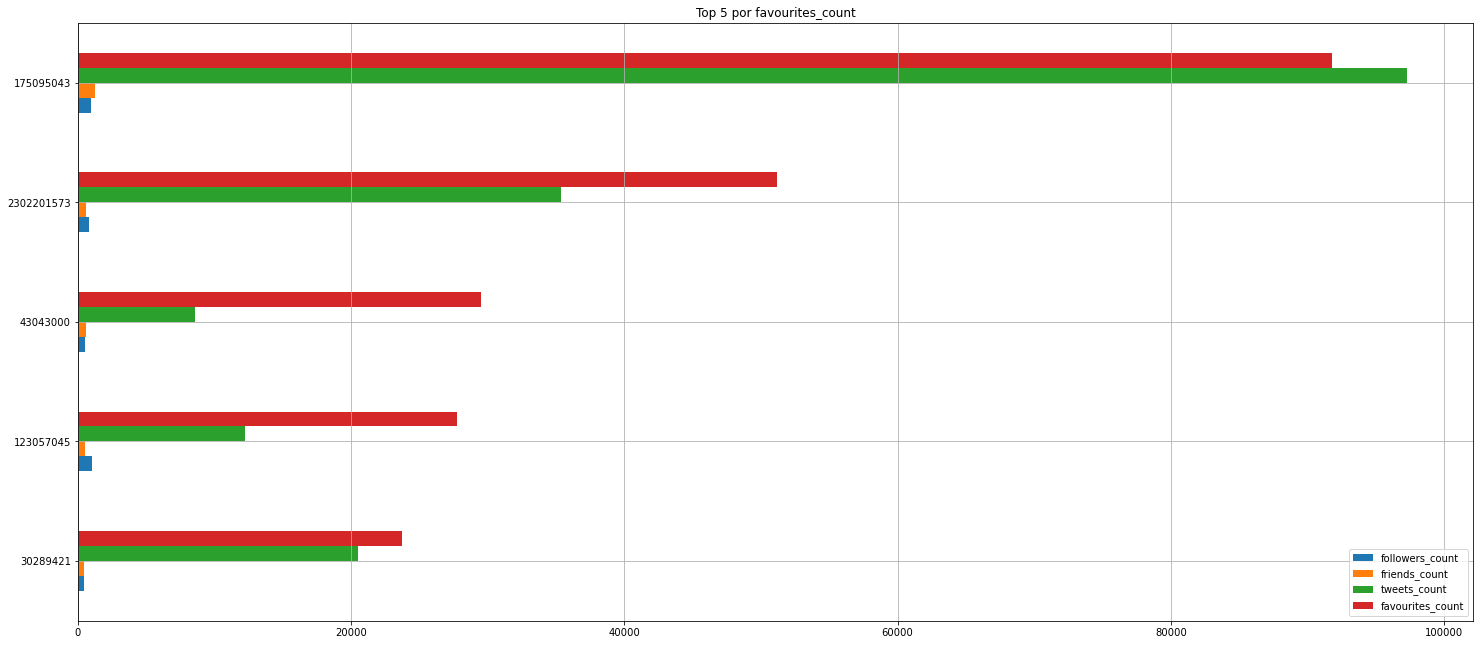

In [15]:
df = seguidores_em_comum

plot_tt_top(df,            #Dataframe com dados do twitter 
            top = 5,       #Tamanho do top por parâmetro definido
            table = False  #Exibe ou não tabela de resumo dos dados
           )

#PS.: I hid the names for privacy reasons

# Pesquisas no twitter

In [16]:
# --Criar função e controlar número de solicitações!
tts = []
for tweet in tweepy.Cursor(tt.search,
                           q="biscoito"
                           ,since="2020-08-17"
                          # ,until="2020-08-06"
                         #  ,lang="pt"
                          ).items(5): #Only 5 tweets
    try:
        tts.append(list((tweet.created_at, tweet.text)))
    except tweepy.TweepError:
        time.sleep(60 * 15)
        count_down(60 * 15)
        continue
    except StopIteration:
        break
    

In [17]:
tts

[[datetime.datetime(2020, 8, 17, 21, 50, 46),
  'A gente ganhou mais um biscoito pra encerrar a noite. 🤩 https://t.co/NoVl3aJpno'],
 [datetime.datetime(2020, 8, 17, 21, 50, 44),
  '@mirimemiri meu segredo é um biscoito da golden que tem quadradinhos. eu corto o comprimido e enfio lá, o besta com… https://t.co/VbZcwqy9ZR'],
 [datetime.datetime(2020, 8, 17, 21, 50, 34),
  'RT @detailscatra: olha oq eu fiz👉👈\n\nda biscoito pfvv🥺🥺 https://t.co/ia3AZWZL1U'],
 [datetime.datetime(2020, 8, 17, 21, 50, 34),
  'sig é um ser muito ligeiro\ntoda vez q ele deixa eu secar a pata dele eu dou um biscoito, agora de pouco ele saiu, d… https://t.co/m1TVapqVtR'],
 [datetime.datetime(2020, 8, 17, 21, 50, 18),
  'RT @_eloisabrito: @Mn_biscoito O brabo é tu, filho!!! ♥']]